## Using Remote Sensing to Predict and Understand Future Wildfires
### by Zeynep Ankut, Isaiah Stene, Corey Becker

In [ ]:
#dummy comment for change to push with

Does the needed imports and downloads the dataset (takes like 5 minutes)

In [3]:
import importFunctions as imp 
import kagglehub

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


path = kagglehub.dataset_download("fantineh/next-day-wildfire-spread")
print("Path to dataset files:", path)

train_files = path + "/next_day_wildfire_spread_train*"
test_files = path + "/next_day_wildfire_spread_test*"
eval_files = path + "/next_day_wildfire_spread_eval*"


train = imp.get_dataset(train_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

test = imp.get_dataset(test_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)


eval_data = imp.get_dataset(test_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

c:\Users\theco\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\theco\.cache\kagglehub\datasets\fantineh\next-day-wildfire-spread\versions\2


In [4]:
def plotRows(start,end,titles,n_features,data):
  inputs, labels = next(iter(data))

  fig = plt.figure(figsize=(15,6.5))

  CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
  BOUNDS = [-1, -0.1, 0.001, 1]
  NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

  n_rows = end-start
  for i in range(n_rows):
    for j in range(n_features + 1):
      plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
      if i == 0:
        plt.title(titles[j], fontsize=13)
      if j < n_features - 1:
        plt.imshow(inputs[i+start, :, :, j], cmap='viridis')
      if j == n_features - 1:
        plt.imshow(inputs[i+start, :, :, -1], cmap=CMAP, norm=NORM)
      if j == n_features:
        plt.imshow(labels[i+start, :, :, 0], cmap=CMAP, norm=NORM) 
      plt.axis('off')
  plt.tight_layout()

  plt.show()

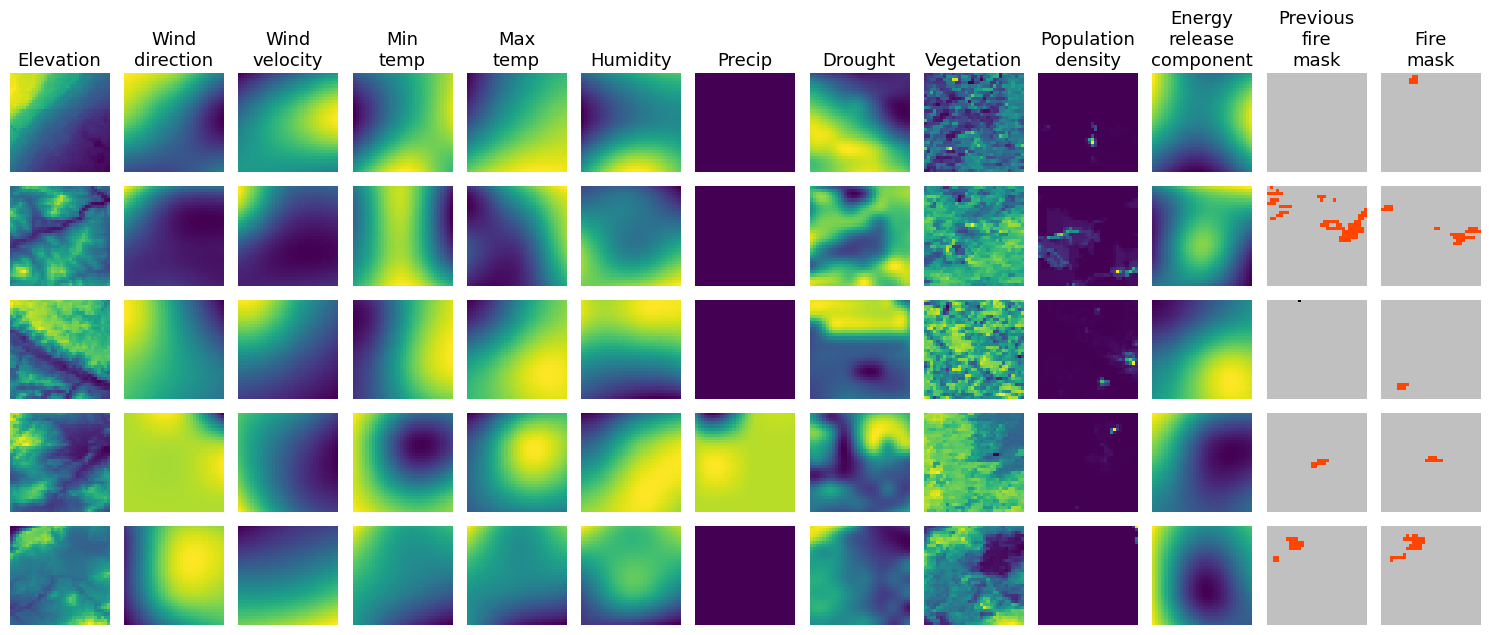

In [5]:
titles = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

plotRows(20,25,titles,len(titles)-1, train)

In [6]:
inputs, labels = next(iter(train))


#now get select features
indices = [1, 2, 3, 4, 5, 6, 10]
tf.gather(inputs, indices, axis=-1)

# # print(labels.shape)

# n_fires, height,width, feat_images = inputs.shape

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, feat_images)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(3)) # there are 3 outputs: fire, no fire, and no data

# model.summary()

<tf.Tensor: shape=(100, 32, 32, 7), dtype=float32, numpy=
array([[[[ 2.30344742e+02,  3.33344650e+00,  2.74924744e+02, ...,
           3.04470537e-03,  0.00000000e+00,  6.33251839e+01],
         [ 2.29960968e+02,  3.34014702e+00,  2.74887238e+02, ...,
           3.04618571e-03,  0.00000000e+00,  6.32584991e+01],
         [ 2.29600037e+02,  3.34651136e+00,  2.74849976e+02, ...,
           3.04763694e-03,  0.00000000e+00,  6.31931305e+01],
         ...,
         [ 2.26812134e+02,  3.38475871e+00,  2.74004578e+02, ...,
           3.07521317e-03,  0.00000000e+00,  6.21202621e+01],
         [ 2.26909851e+02,  3.37175107e+00,  2.74032867e+02, ...,
           3.07611004e-03,  0.00000000e+00,  6.22275467e+01],
         [ 2.27021576e+02,  3.35755157e+00,  2.74066254e+02, ...,
           3.07698292e-03,  0.00000000e+00,  6.23474464e+01]],

        [[ 2.30236649e+02,  3.32718396e+00,  2.74940582e+02, ...,
           3.03863152e-03,  0.00000000e+00,  6.33890610e+01],
         [ 2.29823120e+02,  3.

In [7]:


def build_segmentation_cnn(height,width, features, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(height, width, features)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(num_classes, (1, 1), activation='softmax')
    ])
    return model

def shift_data(labels):
    return tf.maximum(labels,tf.constant([0.]))
        
  

def masked_loss(y_true, y_pred):
    """Compute loss while ignoring -1 values."""
    y_true = tf.squeeze(y_true, axis=-1)  # Remove extra dimension
    mask = tf.not_equal(y_true, -1)  # Mask for valid labels
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')(y_true, y_pred)
    return tf.reduce_mean(tf.boolean_mask(loss, mask))


In [8]:
n_fires, height,width, feat_images = inputs.shape

model = build_segmentation_cnn(height,width,feat_images,2)

labels = shift_data(labels)


c:\Users\theco\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

t_inputs, t_labels = next(iter(test))
e_inputs, e_labels = next(iter(eval_data))

t_labels = shift_data(t_labels)
e_labels = shift_data(e_labels)

tf.gather(t_inputs, indices, axis=-1)
tf.gather(e_inputs, indices, axis=-1)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(inputs, labels, epochs=10, 
                    validation_data=(e_inputs, e_labels))




This is a function to plot the results of the classification, it can plot the actual fire maps vs the predicted fire maps.

In [18]:
def getPredMask(prediction):
  #this takes in the prediction and converts it into a binary image of 1's and 0's based on if the model had a higher probability of no fire (0) or fire (1)

  return np.argmax(prediction,axis=3)


def PlotPredictions(start,end,label,prediction):
  """
  plots pairs of images, one for the actual fire mask, and the next for the predicted firemask from our model.

  Args:
  start (int): the index of the first firemask to use
  end (int): the index of the last fire mask to use, non-inclusive
  label: the actual fire mask
  prediction: the predicted fire mask from the model
  """
    
  n_plots = end - start
  fig, axes = plt.subplots(n_plots, 2, figsize=(12, 4 * n_plots))


  CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
  BOUNDS = [-1, -0.1, 0.001, 1]
  NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

  binPred = getPredMask(prediction)

  for i in range(n_plots):
    #actual fire mask
    axes[i,0].imshow(label[i+start,:,:,0],cmap=CMAP,norm=NORM)
    axes[i, 0].set_title(f"Actual Fire Mask {i + start} ")
    axes[i, 0].axis('off')

    #handles prediction, each prediction has a vector of [p_noFire,p_fire], we will use whatever one is larger
    axes[i,1].imshow(binPred[start+i,:,:],cmap=CMAP,norm=NORM)
    axes[i, 1].set_title(f"predicted Fire Mask {i + start}")
    axes[i, 1].axis('off')

  plt.tight_layout()
  plt.show()


In [ ]:

#gets predictions for train and evaluation data
pMask = model.predict(inputs)
pMask_Eval = model.predict(e_inputs)

PlotPredictions(0,25,e_labels,pMask_Eval)

4/4 - 0s - 55ms/step - accuracy: 0.9493 - loss: 0.4371
0.9493066668510437
4/4 - 0s - 66ms/step - accuracy: 0.9493 - loss: 0.4371
0.9493066668510437


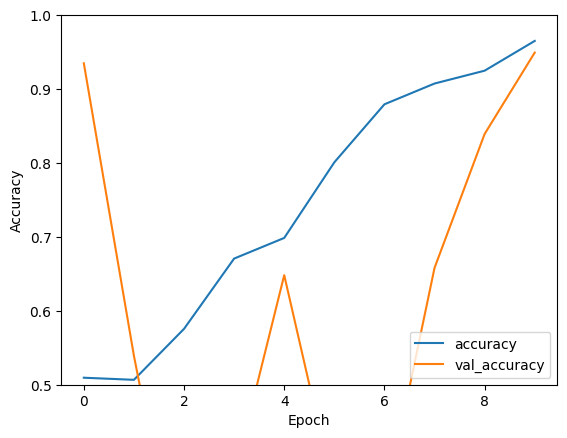

In [23]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(e_inputs,  e_labels, verbose=2)

print(test_acc)



t_loss, test_acc = model.evaluate(e_inputs, e_labels, verbose=2)
print(test_acc)

NEXT STEP: CHECK PREDICTIONS WITH PLOTS AND IMAGES! why is the accuaracy bad :(

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


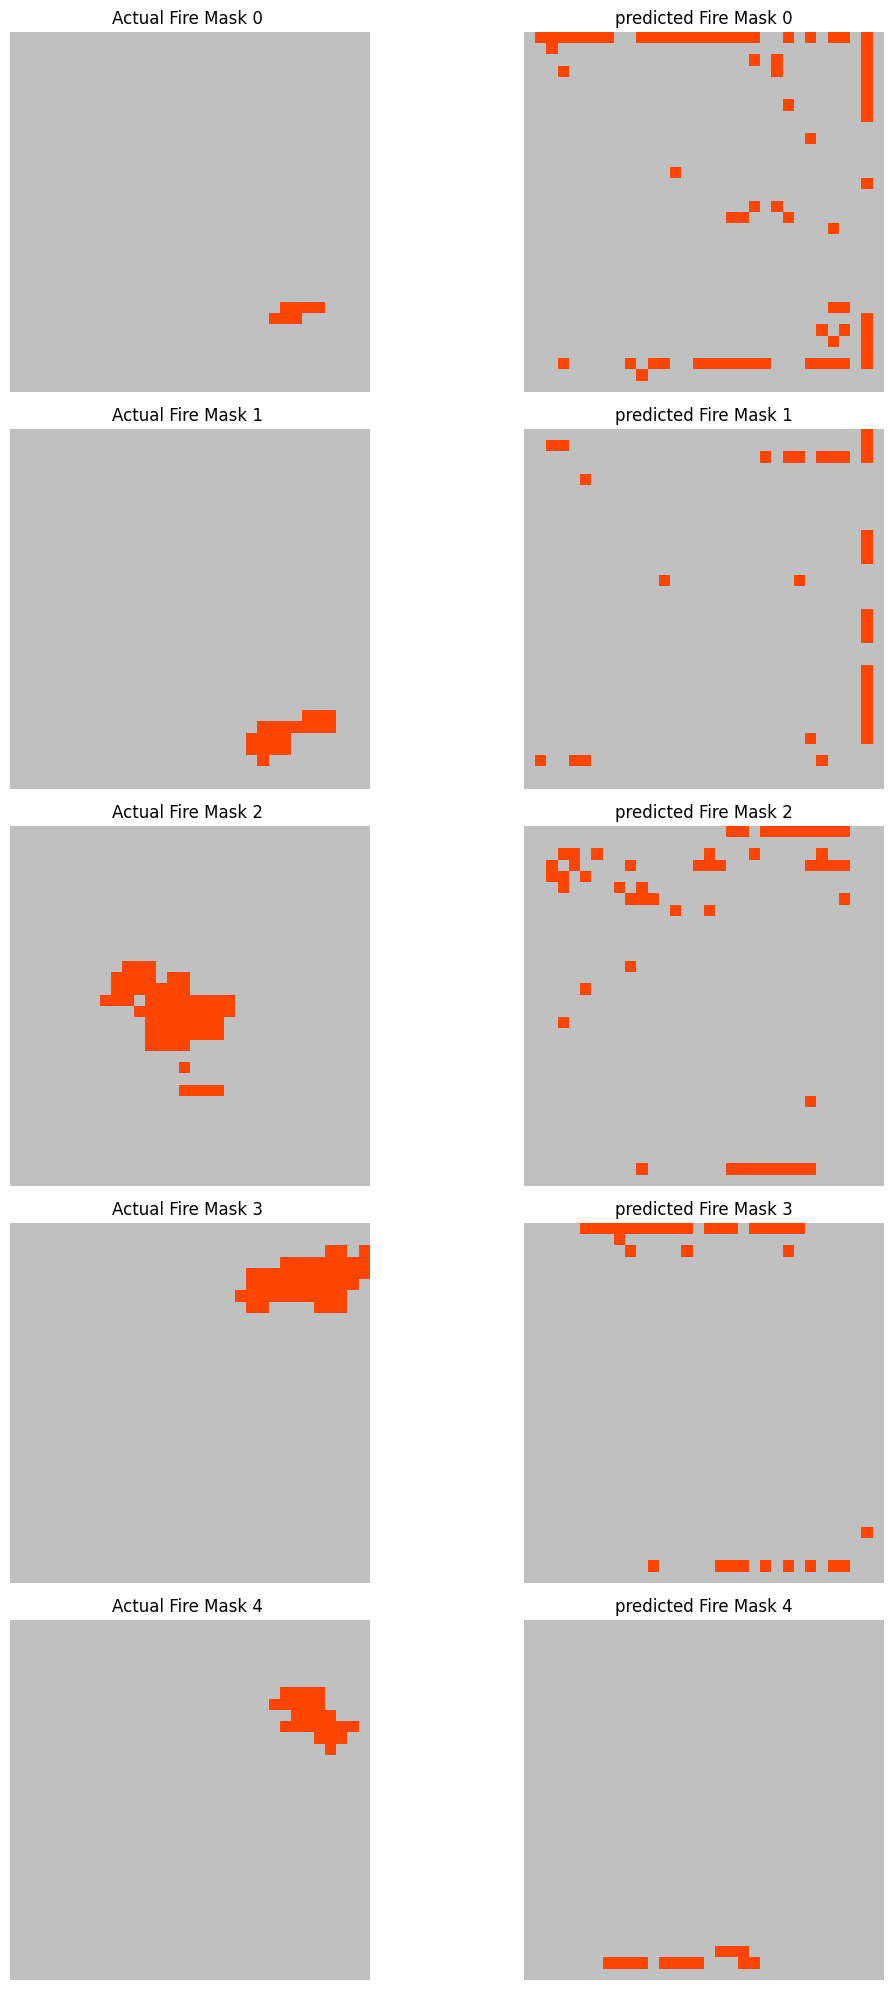

In [24]:
pMask = model.predict(inputs)
pMask_eval = model.predict(e_inputs)

PlotPredictions(0,5,labels,pMask)